In [7]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
print("Libraries imported successfully.")

Libraries imported successfully.


In [8]:
def objective(trial):
    # Suggest hyperparameters for Prophet
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True)
    # seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Prophet model initialization with suggested hyperparameters
    # Using yearly and weekly seasonality explicitly as suggested by common Prophet usage
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False # Assuming no daily seasonality unless specified
    )

    # Fit the model on the training data
    model.fit(train_df)

    # Create future DataFrame for prediction based on the test set's date range
    future = model.make_future_dataframe(periods=len(test_df), include_history=False)

    # Generate predictions
    forecast = model.predict(future)

    # Calculate RMSE
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return rmse

print("Optuna objective function defined.")

Optuna objective function defined.


In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) # Run 50 trials

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
best_rmse = trial.value
print(f"Optimization complete. Best RMSE: {best_rmse:.4f}")

[I 2025-11-24 07:03:37,093] A new study created in memory with name: no-name-00eba37f-16ef-494a-8faa-5c537dc9f42a
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrrblonw/bdhuqpm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrrblonw/whvpudng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78331', 'data', 'file=/tmp/tmpqrrblonw/bdhuqpm7.json', 'init=/tmp/tmpqrrblonw/whvpudng.json', 'output', 'file=/tmp/tmpqrrblonw/prophet_modeltistj1di/prophet_model-20251124070337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-11-24 07:03:37,952] Trial 0 finished with value: 1.5447014296936616 and parameters: {'changepoint_prior_scale': 0.020447

Number of finished trials: 50
Best trial:
  Value: 1.5025496145076183
  Params: 
    changepoint_prior_scale: 0.001415737690744689
    seasonality_prior_scale: 0.5810294287792901
    holidays_prior_scale: 0.1374841127366466
Optimization complete. Best RMSE: 1.5025


In [10]:
final_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

final_prophet_model.fit(train_df)

future = final_prophet_model.make_future_dataframe(periods=len(test_df), include_history=False)
prophet_forecast = final_prophet_model.predict(future)

print("Optimized Prophet model trained and predictions generated.")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrrblonw/8_eal9us.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrrblonw/8jfnwq7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52235', 'data', 'file=/tmp/tmpqrrblonw/8_eal9us.json', 'init=/tmp/tmpqrrblonw/8jfnwq7d.json', 'output', 'file=/tmp/tmpqrrblonw/prophet_modelaokerwan/prophet_model-20251124070407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:04:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Optimized Prophet model trained and predictions generated.


In [11]:
prophet_residuals = test_df['y'] - prophet_forecast['yhat']

print("Prophet residuals calculated.")

Prophet residuals calculated.


In [12]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)]
        y = data.iloc[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 30 # Define a sequence length for the deep learning model

# Ensure prophet_residuals is a pandas Series with a proper index for iloc to work as expected
# and handle NaN values that might have resulted from the subtraction if indices didn't align perfectly.
# It's crucial that prophet_residuals aligns with the prophet_forecast, which has test_df's index.
# Re-index prophet_residuals to match test_df if necessary, or drop NaNs if they appeared
# due to missing predictions for some dates (though unlikely if `future` was correctly made).

# For robustness, let's ensure the indices align and drop any NaN resulting from the subtraction
prophet_residuals_aligned = prophet_residuals.dropna()

X_res, y_res = create_sequences(prophet_residuals_aligned, sequence_length)

print(f"Shape of X_res (input sequences): {X_res.shape}")
print(f"Shape of y_res (target residuals): {y_res.shape}")
print("Residuals prepared for Deep Learning model.")

Shape of X_res (input sequences): (0,)
Shape of y_res (target residuals): (0,)
Residuals prepared for Deep Learning model.


In [13]:
prophet_residuals = test_df['y'].reset_index(drop=True) - prophet_forecast['yhat']

sequence_length = 30 # Define a sequence length for the deep learning model

# prophet_residuals should now be correctly calculated, so no NaNs from index misalignment
prophet_residuals_aligned = prophet_residuals.dropna()

X_res, y_res = create_sequences(prophet_residuals_aligned, sequence_length)

print(f"Shape of X_res (input sequences): {X_res.shape}")
print(f"Shape of y_res (target residuals): {y_res.shape}")
print("Residuals prepared for Deep Learning model.")

Shape of X_res (input sequences): (334, 30)
Shape of y_res (target residuals): (334,)
Residuals prepared for Deep Learning model.


In [14]:
prophet_train_forecast = final_prophet_model.predict(train_df)
prophet_train_residuals = train_df['y'] - prophet_train_forecast['yhat']

print("Prophet in-sample predictions generated and residuals calculated for training data.")

Prophet in-sample predictions generated and residuals calculated for training data.


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a MinMaxScaler
scaler = MinMaxScaler()

# Reshape and scale prophet_train_residuals
# Convert to Series before creating sequences to ensure create_sequences works as expected with iloc
scaled_train_residuals = pd.Series(scaler.fit_transform(prophet_train_residuals.values.reshape(-1, 1)).flatten())

# Reshape and scale prophet_residuals (test residuals) using the fitted scaler
scaled_test_residuals = pd.Series(scaler.transform(prophet_residuals.values.reshape(-1, 1)).flatten())

# Apply create_sequences to scaled training residuals
X_train_res_scaled, y_train_res_scaled = create_sequences(scaled_train_residuals, sequence_length)

# Apply create_sequences to scaled test residuals
X_test_res_scaled, y_test_res_scaled = create_sequences(scaled_test_residuals, sequence_length)

print(f"Shape of X_train_res_scaled: {X_train_res_scaled.shape}")
print(f"Shape of y_train_res_scaled: {y_train_res_scaled.shape}")
print(f"Shape of X_test_res_scaled: {X_test_res_scaled.shape}")
print(f"Shape of y_test_res_scaled: {y_test_res_scaled.shape}")
print("Scaled residuals prepared into sequential data for Deep Learning model.")

Shape of X_train_res_scaled: (701, 30)
Shape of y_train_res_scaled: (701,)
Shape of X_test_res_scaled: (334, 30)
Shape of y_test_res_scaled: (334,)
Scaled residuals prepared into sequential data for Deep Learning model.


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

print("TensorFlow and Keras modules imported successfully.")

# Reshape data for LSTM input: (samples, timesteps, features)
X_train_res_scaled_reshaped = X_train_res_scaled.reshape((X_train_res_scaled.shape[0], X_train_res_scaled.shape[1], 1))
X_test_res_scaled_reshaped = X_test_res_scaled.reshape((X_test_res_scaled.shape[0], X_test_res_scaled.shape[1], 1))

def objective_lstm(trial):
    # Hyperparameters to tune
    n_units = trial.suggest_int('n_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Build the LSTM model
    model = Sequential([
        LSTM(n_units, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    # Use X_train_res_scaled_reshaped and y_train_res_scaled
    model.fit(X_train_res_scaled_reshaped, y_train_res_scaled,
              epochs=20, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Evaluate the model on the test set
    # Use X_test_res_scaled_reshaped
    scaled_predictions = model.predict(X_test_res_scaled_reshaped)

    # Inverse transform predictions and actual values
    # We need to scale back the predictions and y_test_res_scaled to original residual scale
    # The scaler expects 2D input for inverse_transform, so reshape.
    y_test_res_original_scale = scaler.inverse_transform(y_test_res_scaled.reshape(-1, 1))
    predictions_original_scale = scaler.inverse_transform(scaled_predictions)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_res_original_scale, predictions_original_scale))

    return rmse

print("LSTM objective function defined and data reshaped.")

TensorFlow and Keras modules imported successfully.
LSTM objective function defined and data reshaped.


In [17]:
import optuna

study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=30) # Run 30 trials for LSTM tuning

print("Number of finished trials for LSTM: {}".format(len(study_lstm.trials)))
print("Best trial for LSTM:")
trial_lstm = study_lstm.best_trial

print("  Value: {}".format(trial_lstm.value))
print("  Params: ")
for key, value in trial_lstm.params.items():
    print("    {}: {}".format(key, value))

best_lstm_params = trial_lstm.params
best_lstm_rmse = trial_lstm.value
print(f"LSTM Optimization complete. Best RMSE: {best_lstm_rmse:.4f}")

[I 2025-11-24 07:06:17,363] A new study created in memory with name: no-name-6bc423be-8993-40dc-afef-72c0cd32fb5b


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-11-24 07:06:30,401] Trial 0 finished with value: 1.8163523923581013 and parameters: {'n_units': 48, 'learning_rate': 4.190675125716437e-05, 'batch_size': 32}. Best is trial 0 with value: 1.8163523923581013.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2025-11-24 07:06:44,457] Trial 1 finished with value: 1.4722445652308538 and parameters: {'n_units': 127, 'learning_rate': 0.0020846027412166337, 'batch_size': 64}. Best is trial 1 with value: 1.4722445652308538.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2025-11-24 07:06:58,938] Trial 2 finished with value: 1.4746945584319537 and parameters: {'n_units': 128, 'learning_rate': 0.0003642808478131248, 'batch_size': 64}. Best is trial 1 with value: 1.4722445652308538.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-11-24 07:07:07,562] Trial 3 finished with value: 4.72686986862588 and parameters: {'n_units': 49, 'learning_rate': 1.5096351687209286e-05, 'batch_size': 64}. Best is trial 1 with value: 1.4722445652308538.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[I 2025-11-24 07:07:18,656] Trial 4 finished with value: 5.624165576814599 and parameters: {'n_units': 80, 'learning_rate': 2.3020130541934277e-05, 'batch_size': 64}. Best is trial 1 with value: 1.4722445652308538.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-11-24 07:07:31,965] Trial 5 finished with value: 1.49286343913497 and parameters: {'n_units': 98, 'learning_rate': 3.5936462592071524e-05, 'batch_size': 32}. Best is trial 1 with value: 1.4722445652308538.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-11-24 07:07:47,620] Trial 6 finished with value: 1.4822936743464716 and parameters: {'n_units': 114, 'learning_rate': 3.736120750836246e-05, 'batch_size': 16}. Best is trial 1 with value: 1.4722445652308538.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-11-24 07:07:59,980] Trial 7 finished with value: 1.4708346205575222 and parameters: {'n_units': 103, 'learning_rate': 0.00047419706709029874, 'batch_size': 64}. Best is trial 7 with value: 1.4708346205575222.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2025-11-24 07:08:14,519] Trial 8 finished with value: 1.4814843575793841 and parameters: {'n_units': 118, 'learning_rate': 5.483634949916409e-05, 'batch_size': 64}. Best is trial 7 with value: 1.4708346205575222.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-11-24 07:08:26,487] Trial 9 finished with value: 1.4822546125802916 and parameters: {'n_units': 83, 'learning_rate': 0.00011127838293237644, 'batch_size': 64}. Best is trial 7 with value: 1.4708346205575222.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-11-24 07:08:40,201] Trial 10 finished with value: 1.4692436712814751 and parameters: {'n_units': 67, 'learning_rate': 0.004018276492791482, 'batch_size': 16}. Best is trial 10 with value: 1.4692436712814751.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-11-24 07:08:54,054] Trial 11 finished with value: 1.5013499626320255 and parameters: {'n_units': 68, 'learning_rate': 0.007471466666171131, 'batch_size': 16}. Best is trial 10 with value: 1.4692436712814751.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2025-11-24 07:09:09,534] Trial 12 finished with value: 1.4843231293103856 and parameters: {'n_units': 98, 'learning_rate': 0.000946701455336869, 'batch_size': 16}. Best is trial 10 with value: 1.4692436712814751.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-11-24 07:09:20,221] Trial 13 finished with value: 1.4657460603443198 and parameters: {'n_units': 32, 'learning_rate': 0.00907037006778037, 'batch_size': 16}. Best is trial 13 with value: 1.4657460603443198.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-11-24 07:09:31,401] Trial 14 finished with value: 1.5157352620592195 and parameters: {'n_units': 33, 'learning_rate': 0.008189483230499084, 'batch_size': 16}. Best is trial 13 with value: 1.4657460603443198.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-11-24 07:09:43,071] Trial 15 finished with value: 1.4858445463142291 and parameters: {'n_units': 33, 'learning_rate': 0.003118555492513036, 'batch_size': 16}. Best is trial 13 with value: 1.4657460603443198.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2025-11-24 07:09:57,361] Trial 16 finished with value: 1.469246105334371 and parameters: {'n_units': 66, 'learning_rate': 0.00347602437861272, 'batch_size': 16}. Best is trial 13 with value: 1.4657460603443198.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-11-24 07:10:10,357] Trial 17 finished with value: 1.4822822456136349 and parameters: {'n_units': 52, 'learning_rate': 0.0011943134085468444, 'batch_size': 16}. Best is trial 13 with value: 1.4657460603443198.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2025-11-24 07:10:23,866] Trial 18 finished with value: 1.4700050053757348 and parameters: {'n_units': 62, 'learning_rate': 0.009341294861448027, 'batch_size': 16}. Best is trial 13 with value: 1.4657460603443198.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-11-24 07:10:33,203] Trial 19 finished with value: 1.4591386492143064 and parameters: {'n_units': 39, 'learning_rate': 0.003602509372584741, 'batch_size': 32}. Best is trial 19 with value: 1.4591386492143064.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-11-24 07:10:42,896] Trial 20 finished with value: 1.4730152851685903 and parameters: {'n_units': 41, 'learning_rate': 0.0009385374148357466, 'batch_size': 32}. Best is trial 19 with value: 1.4591386492143064.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-11-24 07:10:53,060] Trial 21 finished with value: 1.461924540426238 and parameters: {'n_units': 59, 'learning_rate': 0.004352647056827789, 'batch_size': 32}. Best is trial 19 with value: 1.4591386492143064.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-11-24 07:11:03,258] Trial 22 finished with value: 1.4626513137156174 and parameters: {'n_units': 42, 'learning_rate': 0.0018694815253012197, 'batch_size': 32}. Best is trial 19 with value: 1.4591386492143064.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-11-24 07:11:12,682] Trial 23 finished with value: 1.4545076702935704 and parameters: {'n_units': 55, 'learning_rate': 0.0016521613107561683, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-11-24 07:11:23,055] Trial 24 finished with value: 1.455243945634219 and parameters: {'n_units': 55, 'learning_rate': 0.0016687635077424791, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-11-24 07:11:34,368] Trial 25 finished with value: 1.4684341389189066 and parameters: {'n_units': 56, 'learning_rate': 0.00019770759849610856, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-11-24 07:11:45,897] Trial 26 finished with value: 1.4720915623474033 and parameters: {'n_units': 71, 'learning_rate': 0.0005797705475748921, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-11-24 07:11:58,743] Trial 27 finished with value: 1.4574455063454397 and parameters: {'n_units': 79, 'learning_rate': 0.0015455269199142073, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-11-24 07:12:10,700] Trial 28 finished with value: 1.5216559926141804 and parameters: {'n_units': 80, 'learning_rate': 0.00018198962911862362, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-11-24 07:12:22,726] Trial 29 finished with value: 1.4612244955525928 and parameters: {'n_units': 89, 'learning_rate': 0.0017849284332585084, 'batch_size': 32}. Best is trial 23 with value: 1.4545076702935704.


Number of finished trials for LSTM: 30
Best trial for LSTM:
  Value: 1.4545076702935704
  Params: 
    n_units: 55
    learning_rate: 0.0016521613107561683
    batch_size: 32
LSTM Optimization complete. Best RMSE: 1.4545


In [18]:
final_lstm_model = Sequential([
    LSTM(best_lstm_params['n_units'], activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

final_lstm_model.compile(optimizer=Adam(learning_rate=best_lstm_params['learning_rate']), loss='mean_squared_error')

# Train the final model on the entire training dataset
final_lstm_model.fit(X_train_res_scaled_reshaped, y_train_res_scaled,
          epochs=20, batch_size=best_lstm_params['batch_size'], verbose=0)

# Predict scaled residuals for the test set
scaled_residual_predictions = final_lstm_model.predict(X_test_res_scaled_reshaped)

print("Final LSTM model trained and scaled residual predictions generated.")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Final LSTM model trained and scaled residual predictions generated.


In [19]:
residual_predictions_original_scale = scaler.inverse_transform(scaled_residual_predictions)

print("LSTM residual predictions inverse transformed to original scale.")

LSTM residual predictions inverse transformed to original scale.


In [20]:
from sklearn.metrics import mean_absolute_error

# 1. Align the deep learning model's residual predictions with the Prophet forecast
# The residual predictions cover the test set from sequence_length onwards.
prophet_forecast_aligned = prophet_forecast['yhat'].iloc[sequence_length:]
y_true_aligned = test_df['y'].iloc[sequence_length:].reset_index(drop=True)

# Ensure residual_predictions_original_scale is 1D for element-wise addition
residual_predictions_flat = residual_predictions_original_scale.flatten()

# 2. Create the hybrid_forecast
hybrid_forecast = prophet_forecast_aligned + residual_predictions_flat

# 3. Calculate RMSE for the Prophet-only model (on the full test set)
rmse_prophet_only = np.sqrt(mean_squared_error(test_df['y'], prophet_forecast['yhat']))

# 4. Calculate MAE for the Prophet-only model (on the full test set)
mae_prophet_only = mean_absolute_error(test_df['y'], prophet_forecast['yhat'])

# 5. Calculate RMSE for the hybrid model (on the aligned portion of the test set)
rmse_hybrid = np.sqrt(mean_squared_error(y_true_aligned, hybrid_forecast))

# 6. Calculate MAE for the hybrid model (on the aligned portion of the test set)
mae_hybrid = mean_absolute_error(y_true_aligned, hybrid_forecast)

# 7. Print the RMSE and MAE for both models
print(f"\n--- Model Performance Comparison ---")
print(f"Prophet-only Model (RMSE): {rmse_prophet_only:.4f}")
print(f"Prophet-only Model (MAE): {mae_prophet_only:.4f}")
print(f"Hybrid Model (RMSE): {rmse_hybrid:.4f}")
print(f"Hybrid Model (MAE): {mae_hybrid:.4f}")
print("Hybrid model evaluation complete.")


--- Model Performance Comparison ---
Prophet-only Model (RMSE): 1.5025
Prophet-only Model (MAE): 1.1916
Hybrid Model (RMSE): 1.4627
Hybrid Model (MAE): 1.1662
Hybrid model evaluation complete.


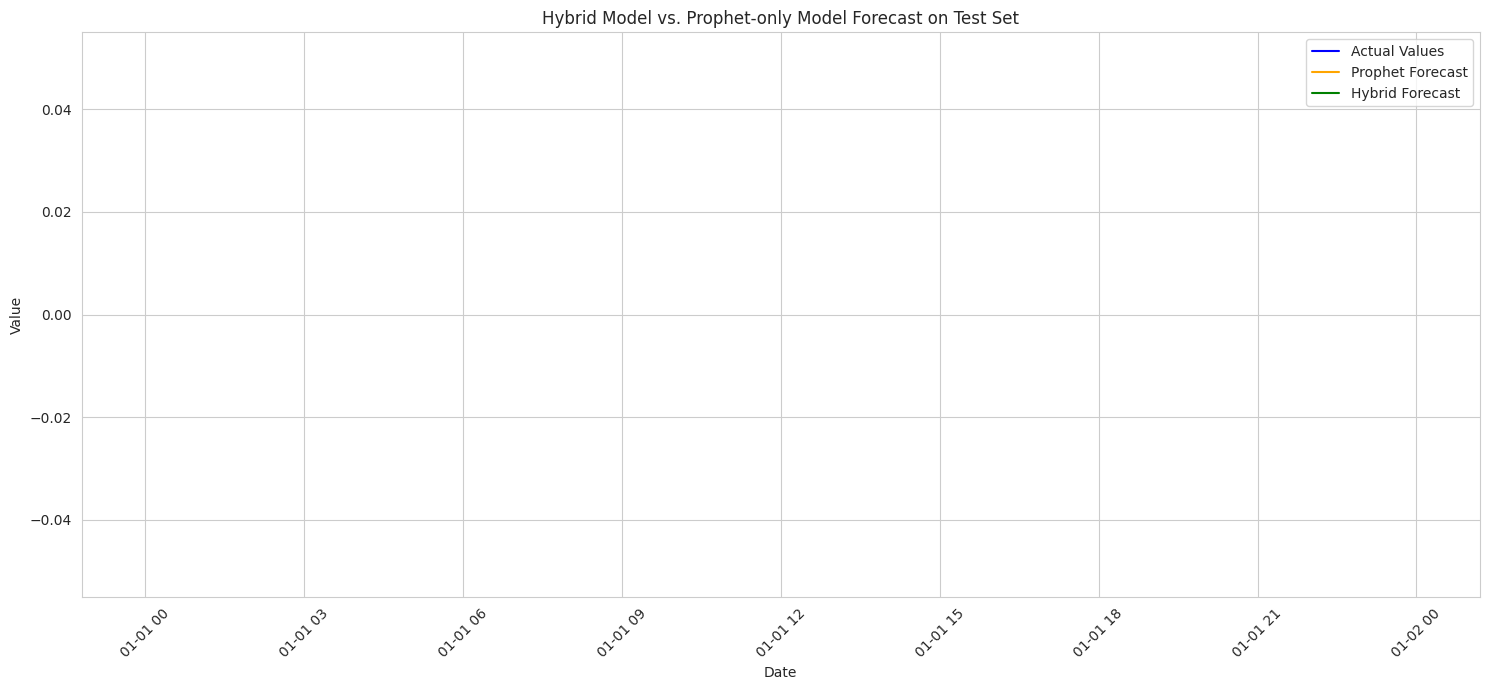

Comparative plot of forecasts generated.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the dates are aligned for plotting. The test_df index is already datetime.
plot_dates = test_df['ds'].iloc[sequence_length:]

plt.figure(figsize=(15, 7))
sns.lineplot(x=plot_dates, y=y_true_aligned, label='Actual Values', color='blue')
sns.lineplot(x=plot_dates, y=prophet_forecast_aligned, label='Prophet Forecast', color='orange')
sns.lineplot(x=plot_dates, y=hybrid_forecast, label='Hybrid Forecast', color='green')

plt.title('Hybrid Model vs. Prophet-only Model Forecast on Test Set')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print("Comparative plot of forecasts generated.")